In [2]:
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
!pip install -U torchtext
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-azgwneta
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-azgwneta
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.6 M

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritanjalijain/fashion-anchor-cloth-pairs")

print("Path to dataset files:", path)


100%|██████████| 14.3G/14.3G [03:09<00:00, 81.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5


In [5]:
import os
os.listdir(path)

['pants_dataset',
 'dress_dataset',
 'bags_dataset',
 'upperwear_dataset',
 'shorts_dataset']

In [6]:
folder=os.listdir(path+'/upperwear_dataset/upperwear_dataset/men_top/cloths')

In [7]:
folder[1:6]

['m5559.png', 'm3560.png', 'm1983.png', 'm1703.png', 'm2999.png']

In [64]:
import torch
import cv2
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from sklearn.cluster import KMeans

# Initialize the model once to reuse it across function calls
def setup_predictor():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
    cfg.MODEL.DEVICE = "cpu"
    return DefaultPredictor(cfg)

predictor = setup_predictor()

# Extract dominant color from a masked object
def extract_dominant_color(image, mask, k=3):
    masked_pixels = image[mask == 1]
    if masked_pixels.size == 0:
        return None
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(masked_pixels)
    dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
    return dominant_color.astype(int)

# # Main function
# def get_dominant_colors(image_bgr):
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#     outputs = predictor(image_rgb)
#     instances = outputs["instances"].to("cpu")
#     masks = instances.pred_masks.numpy()

#     dominant_colors = []
#     for mask in masks:
#         color = extract_dominant_color(image_rgb, mask)
#         if color is not None:
#             dominant_colors.append(color.tolist())  # Convert to list for easier JSON/log output

#     return dominant_colors
def get_dominant_color(image_bgr, k=3):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    outputs = predictor(image_rgb)
    instances = outputs["instances"].to("cpu")
    masks = instances.pred_masks.numpy()

    if len(masks) == 0:
        return None

    # Merge all masks
    combined_mask = np.any(masks, axis=0)

    # Extract only masked pixels from the image
    masked_pixels = image_rgb[combined_mask]

    if masked_pixels.size == 0:
        return None

    # Apply KMeans clustering to get the dominant color
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(masked_pixels)
    dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]

    return dominant_color.astype(int).tolist()





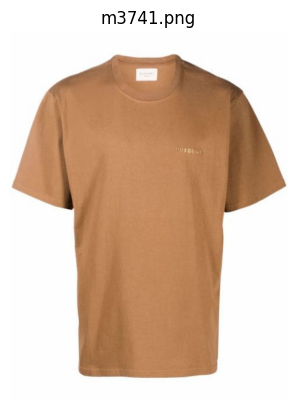

In [58]:
import cv2
import matplotlib.pyplot as plt

image_path = path + '/upperwear_dataset/upperwear_dataset/men_top/cloths/m10010.png'
image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found or path is incorrect")

# Convert BGR (OpenCV format) to RGB (matplotlib format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("m3741.png")
plt.axis('off')
plt.show()


In [59]:
image_path = path+'/upperwear_dataset/upperwear_dataset/men_top/cloths/m10010.png'
image = cv2.imread(image_path)
colors = get_dominant_color(image)
print("Dominant RGB colors:", colors)


Dominant RGB colors: [189, 133, 91]


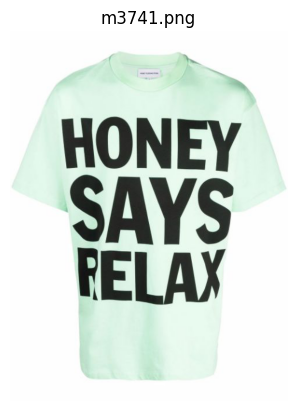

In [60]:
import cv2
import matplotlib.pyplot as plt

image_path = path + '/upperwear_dataset/upperwear_dataset/men_top/cloths/m10005.png'
image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found or path is incorrect")

# Convert BGR (OpenCV format) to RGB (matplotlib format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("m3741.png")
plt.axis('off')
plt.show()


In [61]:
image_path = path + '/upperwear_dataset/upperwear_dataset/men_top/cloths/m10005.png'
image = cv2.imread(image_path)
colors = get_dominant_color(image)
print("Dominant RGB colors:", colors)


Dominant RGB colors: [227, 246, 234]


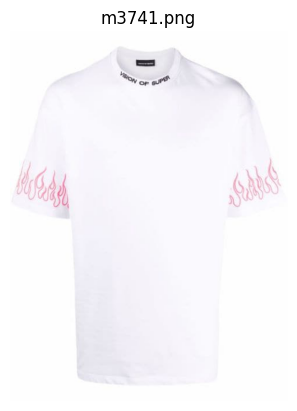

In [65]:
import cv2
import matplotlib.pyplot as plt

image_path = path + '/upperwear_dataset/upperwear_dataset/men_top/cloths/m10028.png'
image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found or path is incorrect")

# Convert BGR (OpenCV format) to RGB (matplotlib format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("m3741.png")
plt.axis('off')
plt.show()

In [66]:
image_path = path + '/upperwear_dataset/upperwear_dataset/men_top/cloths/m10028.png'
image = cv2.imread(image_path)
colors = get_dominant_color(image)
print("Dominant RGB colors:", colors)


Dominant RGB colors: [248, 247, 251]


# using Dictionary

In [67]:
import math

color_names = {
    "black": [0, 0, 0], "white": [255, 255, 255], "red": [255, 0, 0],
    "green": [0, 128, 0], "blue": [0, 0, 255], "yellow": [255, 255, 0],
    "cyan": [0, 255, 255], "magenta": [255, 0, 255], "gray": [128, 128, 128],
    "silver": [192, 192, 192], "maroon": [128, 0, 0], "olive": [128, 128, 0],
    "purple": [128, 0, 128], "teal": [0, 128, 128], "navy": [0, 0, 128],
    "pink": [255, 192, 203], "baby pink": [244, 194, 194], "deep pink": [255, 20, 147],
    "hot pink": [255, 105, 180], "light pink": [255, 182, 193], "salmon": [250, 128, 114],
    "light salmon": [255, 160, 122], "dark salmon": [233, 150, 122],
    "orange": [255, 165, 0], "dark orange": [255, 140, 0], "coral": [255, 127, 80],
    "light coral": [240, 128, 128], "tomato": [255, 99, 71], "peach": [255, 229, 180],
    "beige": [245, 245, 220], "wheat": [245, 222, 179], "moccasin": [255, 228, 181],
    "khaki": [240, 230, 140], "gold": [255, 215, 0], "light yellow": [255, 255, 224],
    "light goldenrod": [250, 250, 210], "lavender": [230, 230, 250], "thistle": [216, 191, 216],
    "plum": [221, 160, 221], "violet": [238, 130, 238], "orchid": [218, 112, 214],
    "fuchsia": [255, 0, 255], "indigo": [75, 0, 130], "dark violet": [148, 0, 211],
    "blue violet": [138, 43, 226], "sky blue": [135, 206, 235], "light blue": [173, 216, 230],
    "powder blue": [176, 224, 230], "steel blue": [70, 130, 180],
    "dodger blue": [30, 144, 255], "royal blue": [65, 105, 225],
    "medium blue": [0, 0, 205], "midnight blue": [25, 25, 112],
    "spring green": [0, 255, 127], "lime green": [50, 205, 50],
    "forest green": [34, 139, 34], "light green": [144, 238, 144],
    "dark green": [0, 100, 0], "sea green": [46, 139, 87],
    "medium sea green": [60, 179, 113], "light sea green": [32, 178, 170],
    "pale green": [152, 251, 152], "turquoise": [64, 224, 208],
    "medium turquoise": [72, 209, 204], "light cyan": [224, 255, 255],
    "azure": [240, 255, 255], "alice blue": [240, 248, 255],
    "mint cream": [245, 255, 250], "honeydew": [240, 255, 240],
    "ivory": [255, 255, 240], "linen": [250, 240, 230],
    "seashell": [255, 245, 238], "snow": [255, 250, 250],
    "ghost white": [248, 248, 255], "floral white": [255, 250, 240],
    "light gray": [211, 211, 211], "dimgray": [105, 105, 105],
    "dark slate gray": [47, 79, 79]
}


# Function to calculate the Euclidean distance between two colors
def color_distance(rgb1, rgb2):
    return math.sqrt(sum([(c1 - c2) ** 2 for c1, c2 in zip(rgb1, rgb2)]))

# Function to find the closest color name
def closest_color_name(rgb_color):
    min_distance = float('inf')
    closest_name = None
    for name, color_rgb in color_names.items():
        distance = color_distance(rgb_color, color_rgb)
        if distance < min_distance:
            min_distance = distance
            closest_name = name
    return closest_name



In [68]:
# Example usage
dominant_rgb = [248, 247, 251]  # Example RGB
color_name = closest_color_name(dominant_rgb)
print("Color name:", color_name)

Color name: ghost white


# using JSON file

In [36]:
import math
import json

# Load the JSON file
with open('/content/extended_color_names.json', 'r') as f:
    color_names = json.load(f)  # It's already a dictionary

# Function to calculate Euclidean distance between two RGB colors
def color_distance(rgb1, rgb2):
    return math.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(rgb1, rgb2)))

# Function to find the closest color name
def closest_color_name(rgb_color):
    min_distance = float('inf')
    closest_name = None
    for name, color_rgb in color_names.items():
        distance = color_distance(rgb_color, color_rgb)
        if distance < min_distance:
            min_distance = distance
            closest_name = name
    return closest_name


In [37]:
# Example usage
dominant_rgb = [227, 246, 234]
color_name2 = closest_color_name(dominant_rgb)
print("Closest color name:", color_name2)

Closest color name: honeydew


In [38]:
import math
import json

# Your color dictionary
color_names = {
    "black": [0, 0, 0], "white": [255, 255, 255], "red": [255, 0, 0],
    "green": [0, 128, 0], "blue": [0, 0, 255], "yellow": [255, 255, 0],
    "cyan": [0, 255, 255], "magenta": [255, 0, 255], "gray": [128, 128, 128],
    "silver": [192, 192, 192], "maroon": [128, 0, 0], "olive": [128, 128, 0],
    "purple": [128, 0, 128], "teal": [0, 128, 128], "navy": [0, 0, 128],
    "pink": [255, 192, 203], "baby pink": [244, 194, 194], "deep pink": [255, 20, 147],
    "hot pink": [255, 105, 180], "light pink": [255, 182, 193], "salmon": [250, 128, 114],
    "light salmon": [255, 160, 122], "dark salmon": [233, 150, 122],
    "orange": [255, 165, 0], "dark orange": [255, 140, 0], "coral": [255, 127, 80],
    "light coral": [240, 128, 128], "tomato": [255, 99, 71], "peach": [255, 229, 180],
    "beige": [245, 245, 220], "wheat": [245, 222, 179], "moccasin": [255, 228, 181],
    "khaki": [240, 230, 140], "gold": [255, 215, 0], "light yellow": [255, 255, 224],
    "light goldenrod": [250, 250, 210], "lavender": [230, 230, 250], "thistle": [216, 191, 216],
    "plum": [221, 160, 221], "violet": [238, 130, 238], "orchid": [218, 112, 214],
    "fuchsia": [255, 0, 255], "indigo": [75, 0, 130], "dark violet": [148, 0, 211],
    "blue violet": [138, 43, 226], "sky blue": [135, 206, 235], "light blue": [173, 216, 230],
    "powder blue": [176, 224, 230], "steel blue": [70, 130, 180],
    "dodger blue": [30, 144, 255], "royal blue": [65, 105, 225],
    "medium blue": [0, 0, 205], "midnight blue": [25, 25, 112],
    "spring green": [0, 255, 127], "lime green": [50, 205, 50],
    "forest green": [34, 139, 34], "light green": [144, 238, 144],
    "dark green": [0, 100, 0], "sea green": [46, 139, 87],
    "medium sea green": [60, 179, 113], "light sea green": [32, 178, 170],
    "pale green": [152, 251, 152], "turquoise": [64, 224, 208],
    "medium turquoise": [72, 209, 204], "light cyan": [224, 255, 255],
    "azure": [240, 255, 255], "alice blue": [240, 248, 255],
    "mint cream": [245, 255, 250], "honeydew": [240, 255, 240],
    "ivory": [255, 255, 240], "linen": [250, 240, 230],
    "seashell": [255, 245, 238], "snow": [255, 250, 250],
    "ghost white": [248, 248, 255], "floral white": [255, 250, 240],
    "light gray": [211, 211, 211], "dimgray": [105, 105, 105],
    "dark slate gray": [47, 79, 79]
}

# Function to calculate the Euclidean distance between two colors
def color_distance(rgb1, rgb2):
    return math.sqrt(sum([(c1 - c2) ** 2 for c1, c2 in zip(rgb1, rgb2)]))

# Function to find the top 3 closest color names
def top_3_closest_colors(rgb_color):
    distances = []
    for name, color_rgb in color_names.items():
        dist = color_distance(rgb_color, color_rgb)
        distances.append((name, dist))
    distances.sort(key=lambda x: x[1])
    return distances[:3]



# Using CSV file

In [24]:
import pandas as pd

df=pd.read_csv('/content/named_colors_rgb.csv')
df

,Color Name,Red,Green,Blue
0,black,0,0,0
1,white,255,255,255
2,red,255,0,0
3,green,0,128,0
4,blue,0,0,255
...,...,...,...,...
73,ghost white,248,248,255
74,floral white,255,250,240
75,light gray,211,211,211
76,dimgray,105,105,105


In [25]:
import math
import csv

# Step 1: Load the CSV file
color_names = {}

# Check the headers of the CSV file to make sure they match
with open('/content/named_colors_rgb.csv', 'r') as file:
    reader = csv.reader(file)
    headers = next(reader)  # Get the headers
    print("CSV Headers:", headers)  # Print headers to confirm

    for row in reader:
        name = row[0]  # Assuming the first column is the color name
        rgb = [int(row[1]), int(row[2]), int(row[3])]  # Assuming the next columns are r, g, b values
        color_names[name] = rgb

# Function to calculate the Euclidean distance between two colors
def color_distance(rgb1, rgb2):
    return math.sqrt(sum([(c1 - c2) ** 2 for c1, c2 in zip(rgb1, rgb2)]))

# Function to find the closest color name
def closest_color_name(rgb_color):
    min_distance = float('inf')
    closest_name = None
    for name, color_rgb in color_names.items():
        distance = color_distance(rgb_color, color_rgb)
        if distance < min_distance:
            min_distance = distance
            closest_name = name
    return closest_name



CSV Headers: ['Color Name', 'Red', 'Green', 'Blue']


In [39]:
# Example usage
dominant_rgb = [227, 246, 234]  # Example RGB
color_name = closest_color_name(dominant_rgb)
print("Color name:", color_name)


Color name: honeydew


In [40]:
import json

# Load the JSON file
with open('/content/extended_color_names.json', 'r') as f:
    color_data = json.load(f)

# Count the number of color records
color_count_json = len(color_data)
print(f"Number of color records in JSON file: {color_count_json}")


Number of color records in JSON file: 78


In [41]:
import csv

# Count the number of color records in the CSV file
color_count_csv = 0

with open('/content/named_colors_rgb.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    color_count_csv = sum(1 for row in reader)  # Count rows

print(f"Number of color records in CSV file: {color_count_csv}")


Number of color records in CSV file: 78


In [45]:
import math
import csv

def get_closest_color_name(rgb_color, csv_path='/content/named_colors_rgb.csv'):
    color_names = {}

    # Load the CSV file
    with open(csv_path, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)

        # Ensure correct headers
        expected_headers = ['Color Name', 'Red', 'Green', 'Blue']
        if headers[:4] != expected_headers:
            raise ValueError(f"Unexpected headers: {headers}. Expected: {expected_headers}")

        for row in reader:
            try:
                name = row[0].strip().lower()
                r = int(row[1])
                g = int(row[2])
                b = int(row[3])
                color_names[name] = [r, g, b]
            except ValueError:
                continue  # Skip rows with invalid data

    # Function to calculate Euclidean distance
    def color_distance(rgb1, rgb2):
        return math.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(rgb1, rgb2)))

    # Find closest color
    min_distance = float('inf')
    closest_name = None
    for name, color_rgb in color_names.items():
        distance = color_distance(rgb_color, color_rgb)
        if distance < min_distance:
            min_distance = distance
            closest_name = name

    return closest_name


In [46]:
dominant_rgb = [227, 246, 234]
color_name = get_closest_color_name(dominant_rgb)
print("Color name:", color_name)


Color name: honeydew


In [48]:
import math
import csv

def get_closest_color_name(rgb_color, csv_path='/content/named_colors_rgb.csv'):
    color_names = {}

    # Load the CSV file
    with open(csv_path, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)

        # Ensure correct headers
        expected_headers = ['Color Name', 'Red', 'Green', 'Blue']
        if headers[:4] != expected_headers:
            raise ValueError(f"Unexpected headers: {headers}. Expected: {expected_headers}")

        for row in reader:
            try:
                name = row[0].strip().lower()
                r = int(row[1])
                g = int(row[2])
                b = int(row[3])
                color_names[name] = [r, g, b]
            except ValueError:
                continue  # Skip rows with invalid data

    # Function to calculate Euclidean distance
    def color_distance(rgb1, rgb2):
        return math.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(rgb1, rgb2)))

    # Find closest color
    min_distance = float('inf')
    closest_name = None
    for name, color_rgb in color_names.items():
        distance = color_distance(rgb_color, color_rgb)
        if distance < min_distance:
            min_distance = distance
            closest_name = name

    return closest_name


In [51]:
dominant_rgb = [27,27,27]
color_name = get_closest_color_name(dominant_rgb)
print("Color name:", color_name)

Color name: black
